## Preparación
Se cargan los datos y se llaman a las librerias que se ocuparán.

In [31]:
# Librerias para cargar datos
import pandas as pd
import numpy as np

from numpy.random import seed
seed(1)

In [32]:
# Se cargan los datos
datos = np.load('datos.npy')
etiquetas = np.load('eti.npy')

In [33]:
# Para usar tensorflow con gpu
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("physical_devices-------------", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

physical_devices------------- 1


In [34]:
#Importamos mas liberias para llevar acabo nuestro modelo
import numpy as np

#import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD, Adam

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pickle


np.random.seed(1)

In [35]:
# Para usar gpu
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


## Modelo
Aquí se crea el modelo y se entrena.

In [36]:
# Se define el perceptron

def architecture(input_shape, num_classes, dropout=False):

    # Se define la entrada como un tensor con dimension input_shape.
    input_layer = Input(input_shape)

    # Se define la primera capa oculta, una capa convolucional con funcion de activacion relu
    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same",name='hl_1')(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    # Se convierte un tensor de dimension (2,64) a un tensor de dimension (128)
    x = Flatten()(conv1)
    if dropout == True:
        x = Dropout(0.5)(x)

    # Se define la segunda capa oculta con 120 nodos y con funcion de activacion relu
    x = Dense(120, kernel_initializer='random_uniform', bias_initializer='zeros', name='hl_2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = Activation('relu')(x)
    if dropout == True:
        x = Dropout(0.45)(x)

    # Se define la tercera capa oculta con 100 nodos y con funcion de activacion relu
    x = Dense(100, kernel_initializer='random_uniform', bias_initializer='zeros', name='hl_3')(x)
    x = keras.layers.BatchNormalization()(x)
    x = Activation('relu')(x)
    if dropout == True:
        x = Dropout(0.35)(x)

    # Se define la cuarta capa oculta con 60 nodos y con funcion de activacion relu
    x = Dense(60, kernel_initializer='random_uniform', bias_initializer='zeros', name='hl_4')(x)
    x = keras.layers.BatchNormalization()(x)
    x = Activation('relu')(x)
    if dropout == True:
        x = Dropout(0.3)(x)

    # Se define la quinta capa oculta con 40 nodos y con funcion de activacion relu
    x = Dense(40, kernel_initializer='random_uniform', bias_initializer='zeros', name='hl_5')(x)
    x = keras.layers.BatchNormalization()(x)
    x = Activation('relu')(x)
    if dropout == True:
        x = Dropout(0.2)(x)


    # Para la capa de salida se ocupó la funcion de activacion softmax
    x = Dense(num_classes, kernel_initializer='random_uniform', bias_initializer='zeros')(x)
    OutputLayer = Activation('softmax', name='output-layer')(x)

    # This creates the Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = input_layer, outputs = OutputLayer, name='Identificador')

    return model

In [37]:
# Defefinimos la dimension de entrada del modelo y el numero de clases que se tiene
# tambien se activa el dropout
one_set = (2, 100)
num_classes=8
dropout=True

with strategy.scope():
  identificador_model = architecture(one_set,num_classes,dropout)

In [38]:
# Definimos un diccionario con las clases que se tiene
dic = {0 : 'constante',1:'lineal',2:'cuadratico',3:'cubico',4:'exponencial',
       5:'sinusoidal',6:'logaritmico',7:'inverso'}

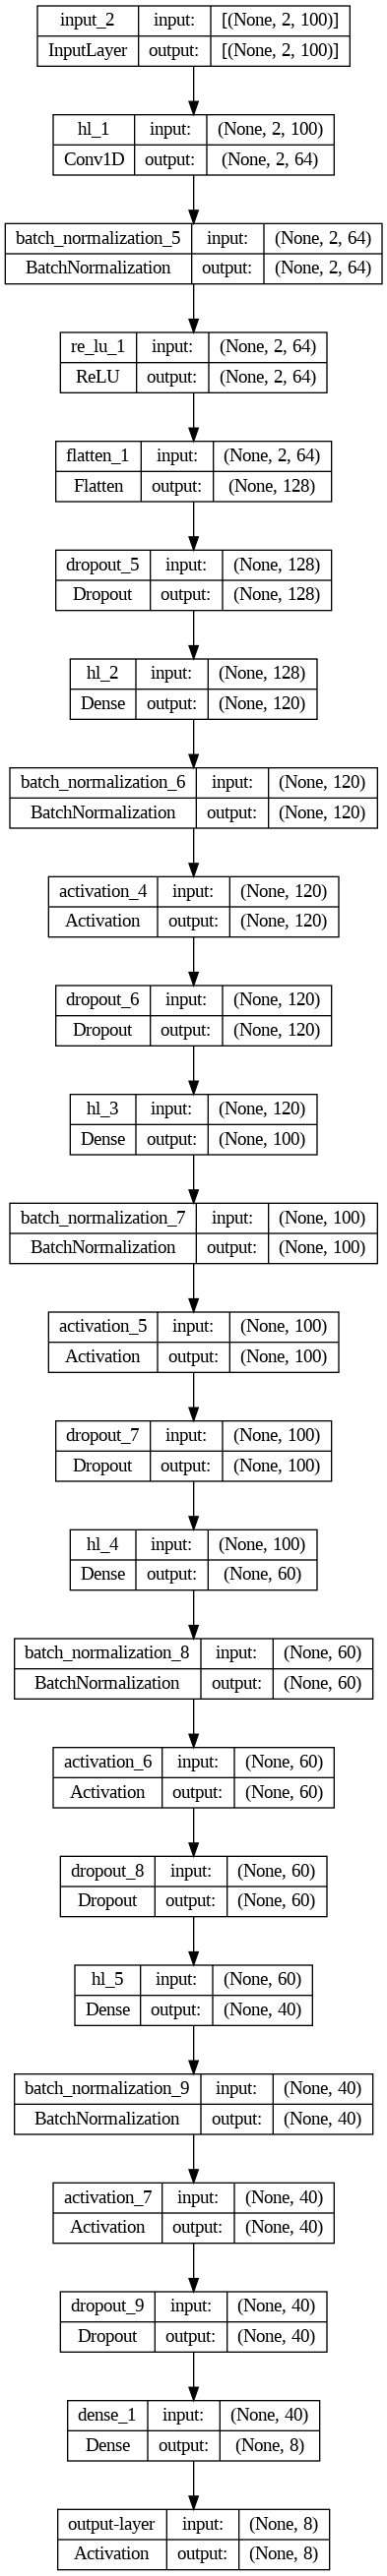

In [39]:
# Visualización del modelo
plot_model(identificador_model, show_shapes=True, rankdir='TB',show_layer_names=True)

In [40]:
# Para visualizar el modelo
from keras_visualizer import visualizer
visualizer(identificador_model,file_name='mod',file_format='png',view=True)

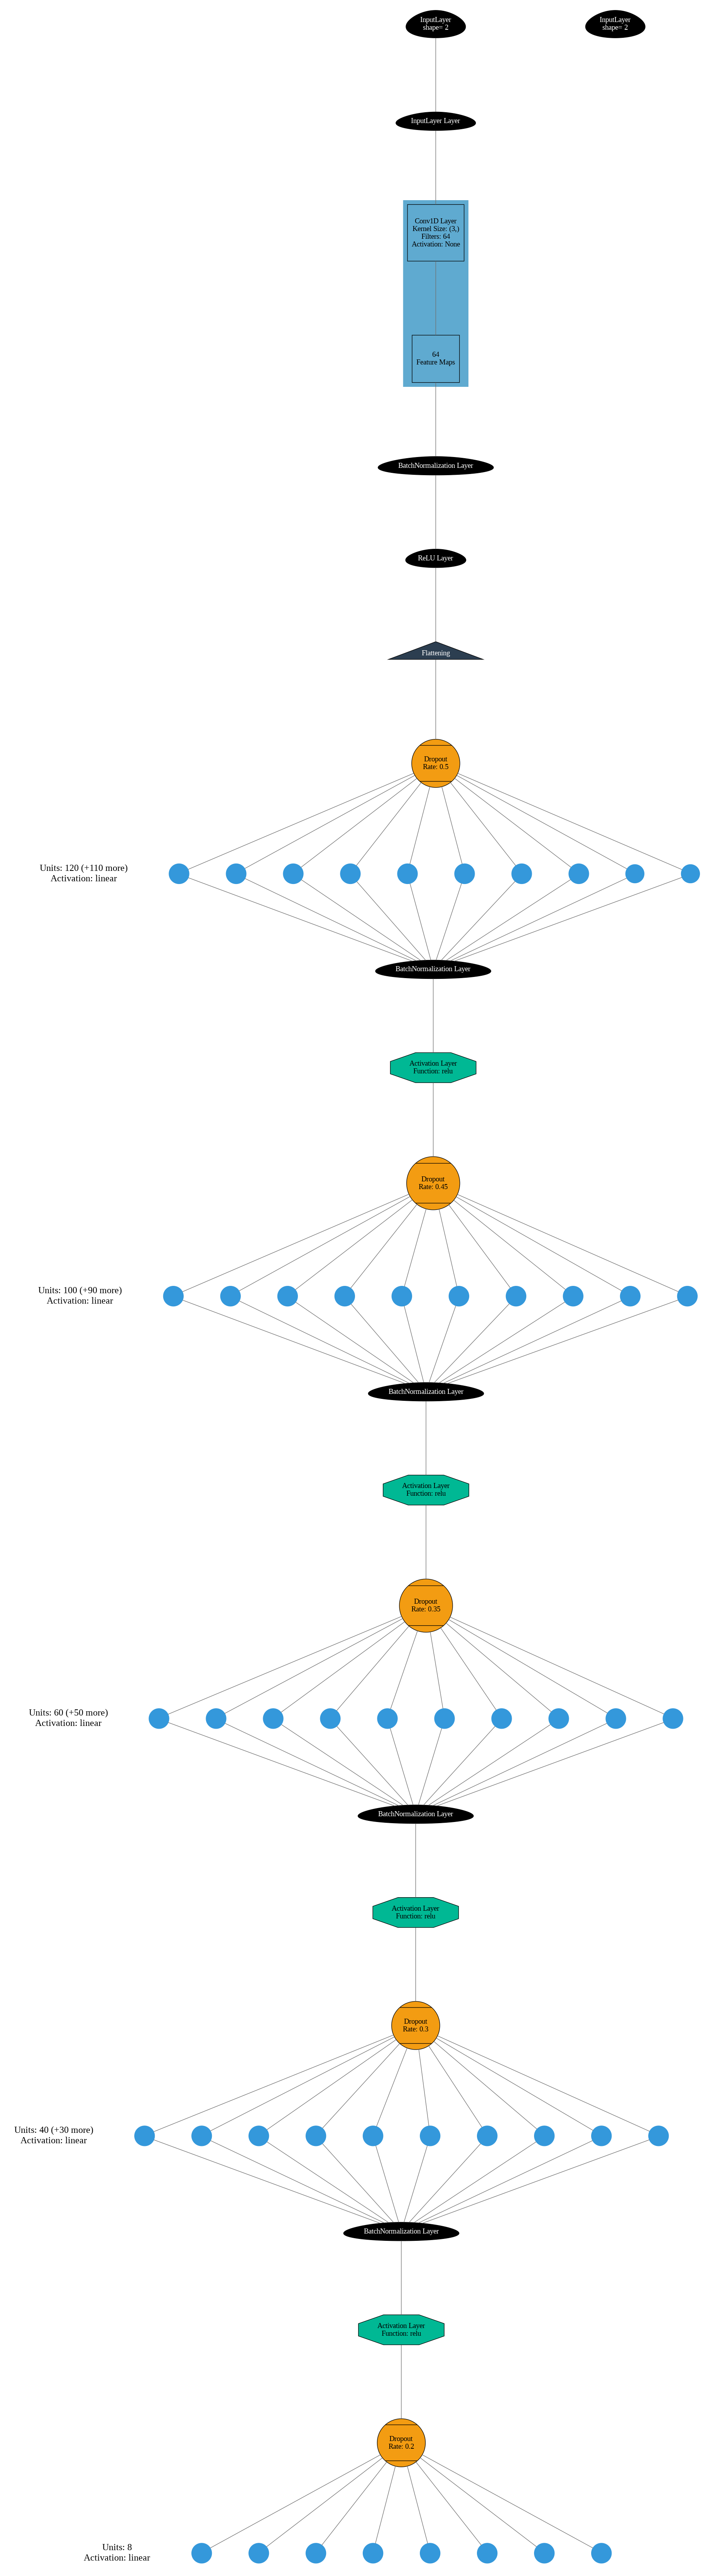

In [41]:
from PIL import Image
im = Image.open('mod.png')
im

In [42]:
# Resumen de las caracteristicas del modelo
identificador_model.summary()

Model: "Identificador"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2, 100)]          0         
                                                                 
 hl_1 (Conv1D)               (None, 2, 64)             19264     
                                                                 
 batch_normalization_5 (Bat  (None, 2, 64)             256       
 chNormalization)                                                
                                                                 
 re_lu_1 (ReLU)              (None, 2, 64)             0         
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                     

In [43]:
# Definimos el algoritmo de optimización que se ocupara
learning_rate = 0.01

optimizer = keras.optimizers.Adam(learning_rate=0.01)

In [44]:
# Se compila el modelo con la funcion de perdida de sparce categorical
# crossentropy debido a que se quiere categorizar

identificador_model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [45]:
# Aquí se entrena el modelo con 300 epocas

validation_portion = 0.2
num_epochs = 300

history = identificador_model.fit(x = datos, y = etiquetas, epochs = num_epochs, batch_size = 128, \
                            validation_split = validation_portion, shuffle=True, verbose=1)

Epoch 1/300
50/50 [==============================] - 5s 17ms/step - loss: 1.3494 - accuracy: 0.4611 - val_loss: 8.9562 - val_accuracy: 0.2431
Epoch 2/300
50/50 [==============================] - 1s 10ms/step - loss: 1.1311 - accuracy: 0.5339 - val_loss: 6.8678 - val_accuracy: 0.2013
Epoch 3/300
50/50 [==============================] - 0s 10ms/step - loss: 1.0534 - accuracy: 0.5731 - val_loss: 3.5481 - val_accuracy: 0.1881
Epoch 4/300
50/50 [==============================] - 0s 10ms/step - loss: 1.0398 - accuracy: 0.5739 - val_loss: 2.0885 - val_accuracy: 0.3506
Epoch 5/300
50/50 [==============================] - 0s 10ms/step - loss: 1.0368 - accuracy: 0.5848 - val_loss: 1.3902 - val_accuracy: 0.4681
Epoch 6/300
50/50 [==============================] - 1s 10ms/step - loss: 1.0703 - accuracy: 0.5750 - val_loss: 1.2310 - val_accuracy: 0.5325
Epoch 7/300
50/50 [==============================] - 1s 11ms/step - loss: 1.0171 - accuracy: 0.5880 - val_loss: 1.2292 - val_accuracy: 0.4950
Epoch 

Las gráficas siguientes dan una primera idea de que tan bueno es el modelo, se busca que la gráfica del conjunto de entrenamiento y del conjunto de validación sean lo más parecidas posibles.

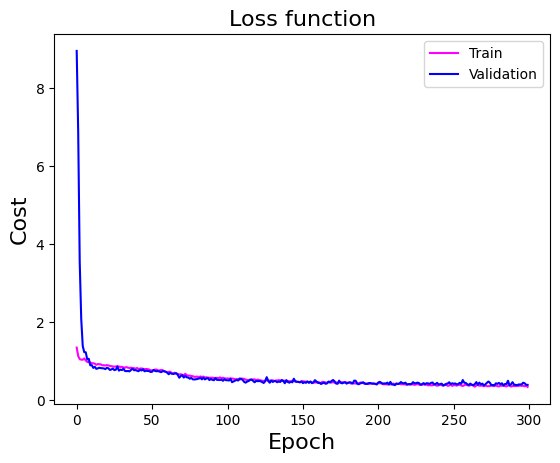

In [46]:
# Graficamos
plt.plot(history.history['loss'], 'magenta')
plt.plot(history.history['val_loss'], 'blue')
plt.title('Loss function', size=16)
plt.ylabel('Cost', size=16)
plt.xlabel('Epoch', size=16)
plt.legend(['Train', 'Validation'], loc='upper right');

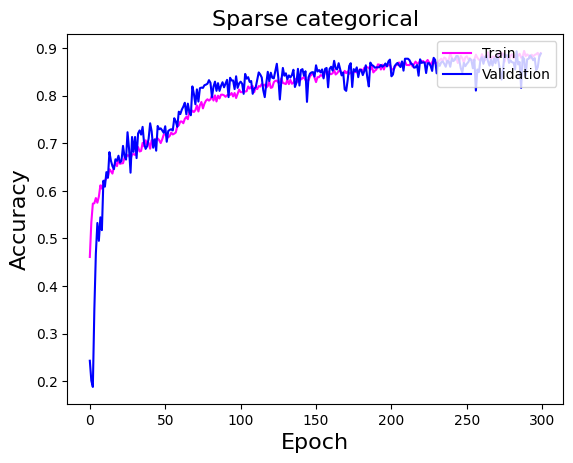

In [47]:
# Graficamos
plt.plot(history.history['accuracy'], 'magenta')
plt.plot(history.history['val_accuracy'], 'blue')
plt.title('Sparse categorical', size=16)
plt.ylabel('Accuracy', size=16)
plt.xlabel('Epoch', size=16)
plt.legend(['Train', 'Validation'], loc='upper right');

Aquí evaluamos el modelo con los mismos datos del entrenamiento. (no es un resultado real)

In [48]:
test_loss, test_acc = identificador_model.evaluate(datos, etiquetas)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

250/250 [==============================] - 1s 3ms/step - loss: 0.2064 - accuracy: 0.9490
Test accuracy 0.9490000009536743
Test loss 0.2064228057861328


In [49]:
# Obtenemos las predicciones
predictions = identificador_model.predict(datos)

250/250 [==============================] - 1s 2ms/step


In [50]:
# Para un conjunto de datos, vemos cual sería el ajuste que el modelo predice
sample = 451
prediction = np.argmax(predictions[sample])
print("Número de la predicción =", prediction,'corresponde un ajuste', dic[prediction])

Número de la predicción = 2 corresponde un ajuste cuadratico


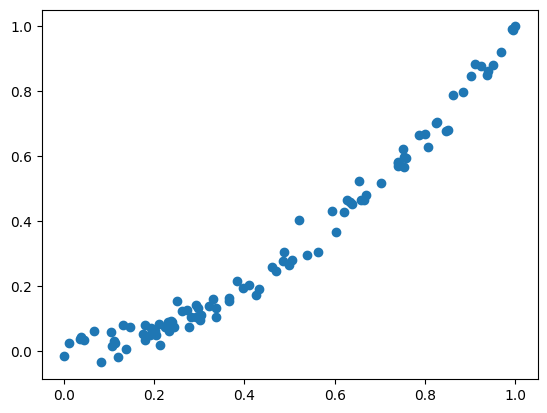

In [51]:
# Comparamos visualmente con la predicción del modelo
plt.scatter(datos[sample][0],datos[sample][1]);

In [52]:
# Comparamos con la etiqueta que tiene el conjunto de datos
dic[etiquetas[sample][0]]

'cuadratico'

## Predicciones
Con un conjunto de datos ajeno al conjunto de entrenamiento, se evaluó la precisión del modelo.

In [53]:
# Se cargan los datos de prueba
datos_prue = np.load('datos_prue.npy')
eti_prue = np.load('eti_prue.npy')

In [54]:
# Evaluación del modelo
test_loss, test_acc = identificador_model.evaluate(datos_prue, eti_prue)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

25/25 [==============================] - 0s 4ms/step - loss: 0.3709 - accuracy: 0.8838
Test accuracy 0.8837500214576721
Test loss 0.3709111511707306


In [97]:
# Obtenemos las predicciones para el conjunto de prueba
predictions = identificador_model.predict(datos_prue)

25/25 [==============================] - 0s 3ms/step


In [98]:
# Para un conjunto de datos, vemos que ajuste predice el modelo
sample = 587
prediction = np.argmax(predictions[sample])
print("Número de la predicción =", prediction,'corresponde un ajuste', dic[prediction])

Número de la predicción = 1 corresponde un ajuste lineal


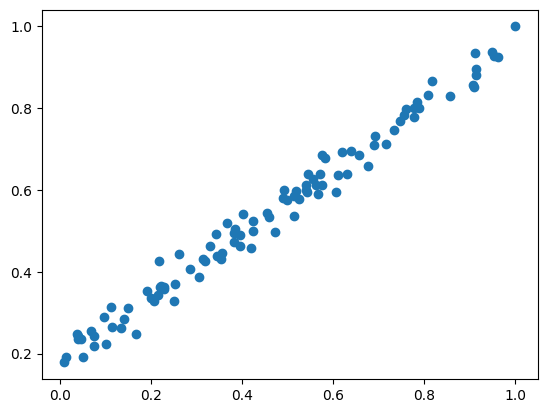

In [99]:
# Comparamos visualente con la prediccion
plt.scatter(datos_prue[sample][0],datos_prue[sample][1]);

In [100]:
# Comparamos la etiqueta del conjunto de datos con la prediccion
dic[eti_prue[sample][0]]

'lineal'

## Ajuste
Después de obtener las predicciones aquí se hace el ajuste de las curvas.

In [177]:
##### Listas de funciones que vamos a utilizar para ajustar
#### valores para la constante
def constante(x,c):
  return c
##### funcion de una recta
def recta(x,m,b):
  return b+m*x
#### funcion de una ecuacion cuadratica
def cuadratica(x,a,b,c):
  return a*x**2+b*x+c
##### funcion de una ecuacion cubica
def cubica(x,a,b,c,d):
  return a*x**3+b*x**2+c*x+d
##### funcion de una ecuacion exponencial
def exponencial(x,A,k,b,c):
  return A*np.exp(k*x+b)+c
#### funcion de un seno
def seno(x,A,w,phi,b):
  return A*np.sin(w*x+phi)+b
##### funcion de un logaritmo
def logaritmo(x,A,k,b,c):
  return A*np.log(k*x+b)+c
#### funcion inversa
def inversa(x,a,b):
  return (a/x)+b

In [80]:
# Cargamos la funcion para ajustar las curvas
from scipy.optimize import curve_fit

In [172]:
# Definimos una funcion que haga el ajuste a partir de las predicciones
def ajuste(sample):
  prediction = np.argmax(predictions[sample])
  x = datos_prue[sample][0]
  y = datos_prue[sample][1]

  # Ajuste constante
  if prediction ==0:
    # curve fit
    popt, _ = curve_fit(constante, x, y)
    # summarize the parameter values
    a = popt
    print('y = %.5f  % (a)')
    # plot input vs output
    plt.scatter(x, y)
    # define a sequence of inputs between the smallest and largest known inputs
    x_line = np.arange(min(x), max(x), 0.001)
    # calculate the output for the range
    y_line = constante(x_line, a)
    # create a line plot for the mapping function
    plt.plot(x_line, y_line,color='red')
    plt.text(0.6,0.2,'y = %.5f' % (a),size=11)
    plt.show();

  # Ajuste lineal
  if prediction ==1:
    # curve fit
    popt, _ = curve_fit(recta, x, y)
    # summarize the parameter values
    a, b = popt
    print('y = %.5f * x + %.5f' % (a, b))
    # plot input vs output
    plt.scatter(x, y)
    # define a sequence of inputs between the smallest and largest known inputs
    x_line = np.arange(min(x), max(x), 0.001)
    # calculate the output for the range
    y_line = recta(x_line, a, b)
    # create a line plot for the mapping function
    plt.plot(x_line, y_line,color='red')
    plt.text(0.6,0.2,'y = %.5f x + %.5f' % (a, b),size=11)
    plt.show();

  # Ajuste cuadratico
  if prediction ==2:
    # curve fit
    popt, _ = curve_fit(cuadratica, x, y)
    # summarize the parameter values
    a, b, c = popt
    print('y = %.5f * x^2 + %.5f * x + %.5f' % (a, b, c))
    # plot input vs output
    plt.scatter(x, y)
    # define a sequence of inputs between the smallest and largest known inputs
    x_line = np.arange(min(x), max(x), 0.001)
    # calculate the output for the range
    y_line = cuadratica(x_line, a, b, c)
    # create a line plot for the mapping function
    plt.plot(x_line, y_line, color='red')
    plt.text(0.6,0.2,'y = %.5f * x^2 + %.5f * x + %.5f' % (a, b, c),size=11)
    plt.show();

  # Ajuste cubico
  if prediction ==3:
    # curve fit
    popt, _ = curve_fit(cubica, x, y)
    # summarize the parameter values
    a, b, c, d = popt
    print('y = %.5f * x^3 + %.5f * x^2 + %.5f * x + %.5f' % (a, b, c, d))
    # plot input vs output
    plt.scatter(x, y)
    # define a sequence of inputs between the smallest and largest known inputs
    x_line = np.arange(min(x), max(x), 0.001)
    # calculate the output for the range
    y_line = cubica(x_line, a, b, c, d)
    # create a line plot for the mapping function
    plt.plot(x_line, y_line, color='red')
    plt.text(0.6,0.2,'y = %.5f * x^3 + %.5f * x^2 + %.5f * x + %.5f' % (a, b, c, d),size=11)
    plt.show();

  # Ajuste exponencial
  if prediction ==4:
    # curve fit
    popt, _ = curve_fit(exponencial, x, y)
    # summarize the parameter values
    A, k, b, c = popt
    print('y = %.5f * exp(%.5f * x + %.5f ) + %.5f' % (A, k, b, c))
    # plot input vs output
    plt.scatter(x, y)
    # define a sequence of inputs between the smallest and largest known inputs
    x_line = np.arange(min(x), max(x), 0.001)
    # calculate the output for the range
    y_line = exponencial(x_line, A, k, b, c)
    # create a line plot for the mapping function
    plt.plot(x_line, y_line, color='red')
    plt.text(0.6,0.2,'y = %.5f * exp(%.5f * x + %.5f ) + %.5f' % (A, k, b, c),size=11)
    plt.show();

  # Ajuste sinusoidal
  if prediction ==5:
    # curve fit
    popt, _ = curve_fit(seno, x, y)
    # summarize the parameter values
    A, w, phi, b = popt
    print('y = %.5f * sin(%.5f * x + %.5f ) + %.5f' % (A, w, phi, b))
    # plot input vs output
    plt.scatter(x, y)
    # define a sequence of inputs between the smallest and largest known inputs
    x_line = np.arange(min(x), max(x), 0.001)
    # calculate the output for the range
    y_line = seno(x_line, A, w, phi, b)
    # create a line plot for the mapping function
    plt.plot(x_line, y_line, color='red')
    plt.text(0.6,0.2,'y = %.5f * sin(%.5f * x + %.5f ) + %.5f' % (A, w, phi, b),size=11)
    plt.show();

  # Ajuste logaritmico
  if prediction ==6:
    # curve fit
    popt, _ = curve_fit(logaritmo, x, y)
    # summarize the parameter values
    A, k, b, c = popt
    print('y = %.5f * log(%.5f * x + %.5f ) + %.5f' % (A, k, b, c))
    # plot input vs output
    plt.scatter(x, y)
    # define a sequence of inputs between the smallest and largest known inputs
    x_line = np.arange(min(x), max(x), 0.001)
    # calculate the output for the range
    y_line = logaritmo(x_line, A, k, b, c)
    # create a line plot for the mapping function
    plt.plot(x_line, y_line, color='red')
    plt.text(0.6,0.2,'y = %.5f * log(%.5f * x + %.5f ) + %.5f' % (A, k, b, c),size=11)
    plt.show();

  # Ajuste funcion inversa
  if prediction ==7:
    # curve fit
    popt, _ = curve_fit(inversa, x, y)
    # summarize the parameter values
    a, b = popt
    print('y = %.5f / x + %.5f' % (a, b))
    # plot input vs output
    plt.scatter(x, y)
    # define a sequence of inputs between the smallest and largest known inputs
    x_line = np.arange(min(x), max(x), 0.001)
    # calculate the output for the range
    y_line = inversa(x_line, a, b)
    # create a line plot for the mapping function
    plt.plot(x_line, y_line,color='red')
    plt.text(0.6,0.6,'y = %.5f / x + %.5f' % (a, b),size=11)
    plt.show();


y = 0.77694 * x + 0.18465


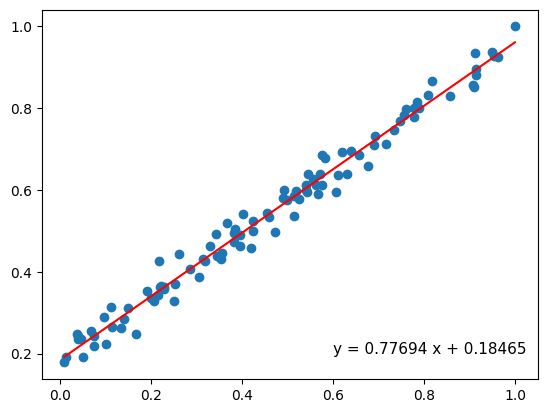

In [176]:
# Ejemplos de ajustes
ajuste(sample)

Número de la predicción = 6 corresponde un ajuste logaritmico
y = 0.20057 * log(1.85304 * x + 0.18035 ) + 0.84389


<ipython-input-69-35b98317f244>:22: RuntimeWarning: invalid value encountered in log
  return A*np.log(k*x+b)+c


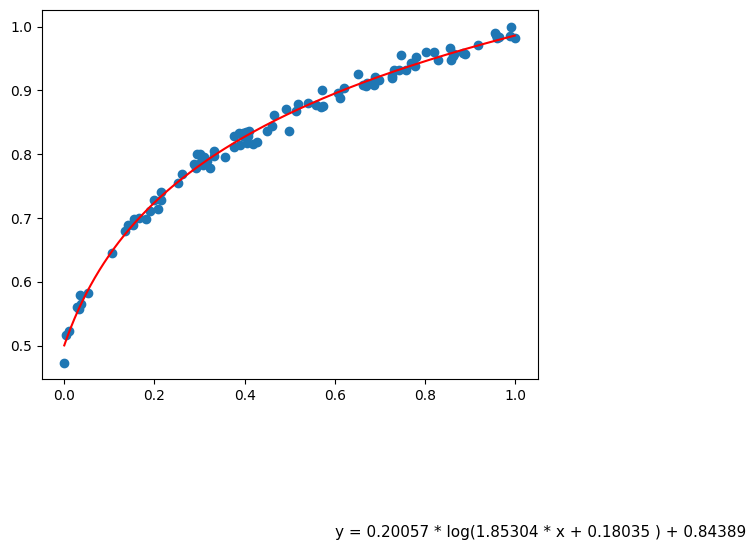

In [174]:
p =2
prediction = np.argmax(predictions[p])
print("Número de la predicción =", prediction,'corresponde un ajuste', dic[prediction])
ajuste(p)

Número de la predicción = 2 corresponde un ajuste cuadratico
y = 0.78941 * x^2 + 0.21065 * x + -0.04068


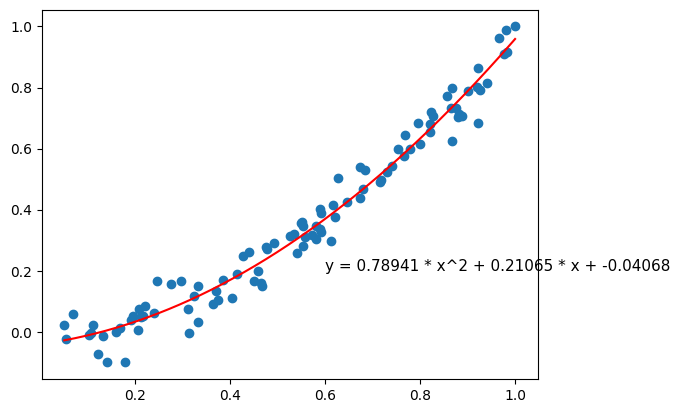

In [175]:
p =387
prediction = np.argmax(predictions[p])
print("Número de la predicción =", prediction,'corresponde un ajuste', dic[prediction])
ajuste(p)